In [29]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'resnet50_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
! unzip -o /content/drive/MyDrive/dataset_19.zip
# ! unzip -o /content/drive/MyDrive/Brain_MRI.zip
!pip install optuna optuna-integration
! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: dataset_19/glioma/Te-gl_012

# Load the data

In [32]:
# Data Directories
dir = "dataset_19/"
# validation_dir = "Testing"

# Data distribution

In [33]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

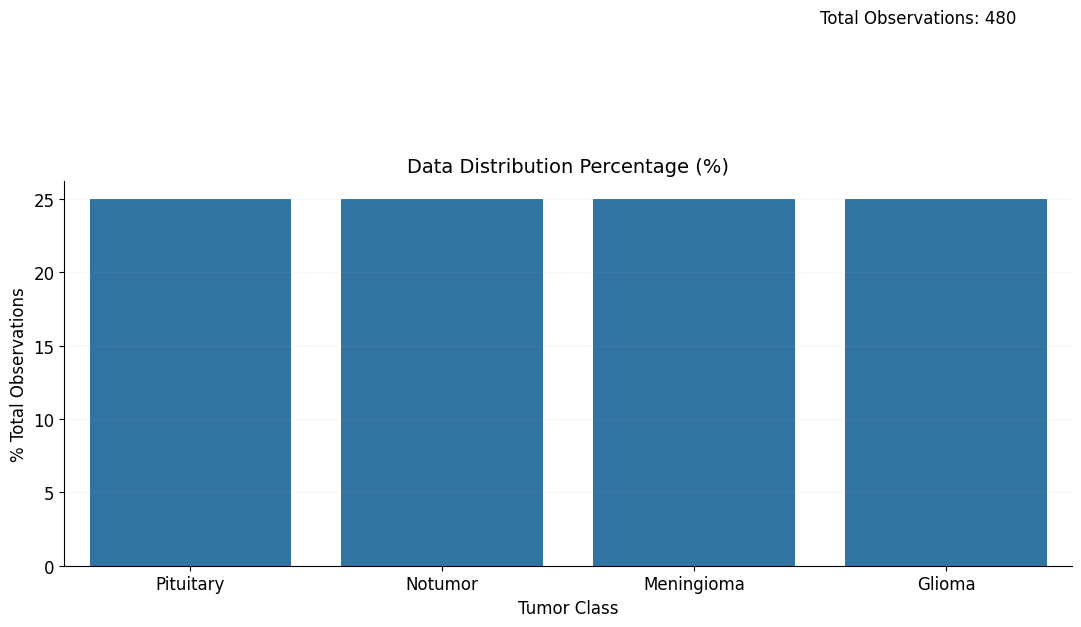

In [34]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

In [7]:
# from tqdm import tqdm
# import cv2
# import imutils

# def crop_img(img):

# 	# Find extreme points on the image and crop the rectangular out

# 	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# 	gray = cv2.GaussianBlur(gray, (3, 3), 0)

# 	# threshold the image, then perform a series of erosions +
# 	# dilations to remove any small regions of noise
# 	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
# 	thresh = cv2.erode(thresh, None, iterations=2)
# 	thresh = cv2.dilate(thresh, None, iterations=2)

# 	# find contours in thresholded image, then grab the largest one
# 	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 	cnts = imutils.grab_contours(cnts)
# 	c = max(cnts, key=cv2.contourArea)

# 	# find the extreme points
# 	extLeft = tuple(c[c[:, :, 0].argmin()][0])
# 	extRight = tuple(c[c[:, :, 0].argmax()][0])
# 	extTop = tuple(c[c[:, :, 1].argmin()][0])
# 	extBot = tuple(c[c[:, :, 1].argmax()][0])
# 	ADD_PIXELS = 0
# 	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# 	return new_img

# def preprocess_images(directory):
#     for dir in os.listdir(directory):
#         path = os.path.join(directory, dir)
#         for img_name in os.listdir(path):
#             img_path = os.path.join(path, img_name)
#             img = cv2.imread(img_path)
#             cropped_img = crop_img(img)
#             cv2.imwrite(img_path, cropped_img)

# # Preprocess the images before generating data
# preprocess_images(dir)

# Fine tuning hyperparameters

In [ ]:
import os
import optuna
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet50
from keras.utils import plot_model

classes = os.listdir(dir)

# Data generator setup
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

# Model creation function modified for Optuna
def create_model(input_shape, num_classes, trial):
    # Suggest hyperparameters
    n_neurons = trial.suggest_int('n_neurons', 256, 1024, log=True)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(n_neurons, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model with suggested learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    # Get suggested batch size
    batch_size = 8

    train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='training'
    )

    test_generator = validation_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='validation'
    )

    model = create_model((224, 224, 3), len(classes), trial)
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=50,
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best weights before returning the final validation loss
    model.load_weights(model_file)

    # Store the training history in the trial
    trial.set_user_attr('history', history.history)

    # Evaluate the model with the best weights on the validation set
    val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

history = trial.user_attrs['history']

[I 2024-06-05 01:31:09,088] A new study created in memory with name: no-name-485d449b-7563-4c74-b23f-263634c1d91f


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


<ipython-input-10-333ed010ca65>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-10-333ed010ca65>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.9285 - accuracy: 0.6589
Epoch 1: val_loss improved from inf to 3.66649, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 46s 289ms/step - loss: 0.9285 - accuracy: 0.6589 - val_loss: 3.6665 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.8333
Epoch 2: val_loss improved from 3.66649 to 1.66073, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 11s 230ms/step - loss: 0.4889 - accuracy: 0.8333 - val_loss: 1.6607 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.8255
Epoch 3: val_loss did not improve from 1.66073
48/48 [==============================] - 7s 146ms/step - loss: 0.4630 - accuracy: 0.8255 - val_loss: 2.5610 - val_accuracy: 0.2500
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8776


[I 2024-06-05 01:40:01,894] Trial 0 finished with value: 0.5340961217880249 and parameters: {'n_neurons': 331, 'dropout_rate': 0.20791131754360528, 'learning_rate': 0.00026850358203780544}. Best is trial 0 with value: 0.5340961217880249.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.5052
Epoch 1: val_loss improved from inf to 1.49866, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 52s 440ms/step - loss: 1.1450 - accuracy: 0.5052 - val_loss: 1.4987 - val_accuracy: 0.3125
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7682
Epoch 2: val_loss did not improve from 1.49866
48/48 [==============================] - 8s 164ms/step - loss: 0.6248 - accuracy: 0.7682 - val_loss: 1.5055 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8542
Epoch 3: val_loss improved from 1.49866 to 1.45582, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 10s 213ms/step - loss: 0.4396 - accuracy: 0.8542 - val_loss: 1.4558 - val_accuracy: 0.1354
Epoch 4/50
48

[I 2024-06-05 01:50:07,168] Trial 1 finished with value: 0.45941928029060364 and parameters: {'n_neurons': 607, 'dropout_rate': 0.4505851250939067, 'learning_rate': 2.789949972458153e-05}. Best is trial 1 with value: 0.45941928029060364.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.0297 - accuracy: 0.5469
Epoch 1: val_loss improved from inf to 1.65827, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 55s 456ms/step - loss: 1.0297 - accuracy: 0.5469 - val_loss: 1.6583 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.8229
Epoch 2: val_loss improved from 1.65827 to 1.58247, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 20s 408ms/step - loss: 0.4728 - accuracy: 0.8229 - val_loss: 1.5825 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8906
Epoch 3: val_loss did not improve from 1.58247
48/48 [==============================] - 8s 159ms/step - loss: 0.3406 - accuracy: 0.8906 - val_loss: 1.6540 - val_accuracy: 0.2604
Epoch 4/50
48

[I 2024-06-05 02:01:32,499] Trial 2 finished with value: 0.35516273975372314 and parameters: {'n_neurons': 452, 'dropout_rate': 0.4375364644033507, 'learning_rate': 4.6368996602969245e-05}. Best is trial 2 with value: 0.35516273975372314.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.2822 - accuracy: 0.4193
Epoch 1: val_loss improved from inf to 1.51060, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 57s 498ms/step - loss: 1.2822 - accuracy: 0.4193 - val_loss: 1.5106 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.7422
Epoch 2: val_loss did not improve from 1.51060
48/48 [==============================] - 8s 164ms/step - loss: 0.7750 - accuracy: 0.7422 - val_loss: 1.5555 - val_accuracy: 0.1875
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.8333
Epoch 3: val_loss did not improve from 1.51060
48/48 [==============================] - 8s 175ms/step - loss: 0.5727 - accuracy: 0.8333 - val_loss: 1.6848 - val_accuracy: 0.1458
Epoch 4/50
48/48 [==============================] - ETA: 0s 

[I 2024-06-05 02:16:09,525] Trial 3 finished with value: 0.3539711534976959 and parameters: {'n_neurons': 561, 'dropout_rate': 0.1396316134121273, 'learning_rate': 1.1788864541114867e-05}. Best is trial 3 with value: 0.3539711534976959.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.9767 - accuracy: 0.6823
Epoch 1: val_loss improved from inf to 3.16835, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 49s 338ms/step - loss: 0.9767 - accuracy: 0.6823 - val_loss: 3.1684 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.7978 - accuracy: 0.7031
Epoch 2: val_loss improved from 3.16835 to 2.76700, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 21s 437ms/step - loss: 0.7978 - accuracy: 0.7031 - val_loss: 2.7670 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8464
Epoch 3: val_loss did not improve from 2.76700
48/48 [==============================] - 9s 176ms/step - loss: 0.4501 - accuracy: 0.8464 - val_loss: 20.2138 - val_accuracy: 0.2500
Epoch 4/50
4

[I 2024-06-05 02:27:24,334] Trial 4 finished with value: 0.4560734033584595 and parameters: {'n_neurons': 709, 'dropout_rate': 0.11439629643024025, 'learning_rate': 0.00038209218035891313}. Best is trial 3 with value: 0.3539711534976959.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.2918 - accuracy: 0.6068
Epoch 1: val_loss improved from inf to 14.37987, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 51s 423ms/step - loss: 1.2918 - accuracy: 0.6068 - val_loss: 14.3799 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.7760
Epoch 2: val_loss did not improve from 14.37987
48/48 [==============================] - 9s 181ms/step - loss: 0.6448 - accuracy: 0.7760 - val_loss: 216.2134 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.7500
Epoch 3: val_loss improved from 14.37987 to 3.06914, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 31s 653ms/step - loss: 0.7275 - accuracy: 0.7500 - val_loss: 3.0691 - val_accuracy: 0.2500
Epoch 4

[I 2024-06-05 02:39:15,497] Trial 5 finished with value: 0.4784374535083771 and parameters: {'n_neurons': 964, 'dropout_rate': 0.31857234766982856, 'learning_rate': 0.00044302520785414134}. Best is trial 3 with value: 0.3539711534976959.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.8154 - accuracy: 0.6979
Epoch 1: val_loss improved from inf to 1.65180, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 61s 592ms/step - loss: 0.8154 - accuracy: 0.6979 - val_loss: 1.6518 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.8802
Epoch 2: val_loss did not improve from 1.65180
48/48 [==============================] - 7s 148ms/step - loss: 0.3797 - accuracy: 0.8802 - val_loss: 2.8817 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9219
Epoch 3: val_loss did not improve from 1.65180
48/48 [==============================] - 8s 170ms/step - loss: 0.2056 - accuracy: 0.9219 - val_loss: 1.9960 - val_accuracy: 0.2708
Epoch 4/50
48/48 [==============================] - ETA: 0s 

[I 2024-06-05 02:52:13,100] Trial 6 finished with value: 0.21667979657649994 and parameters: {'n_neurons': 888, 'dropout_rate': 0.18493736734850438, 'learning_rate': 0.00010353032613795179}. Best is trial 6 with value: 0.21667979657649994.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.8678 - accuracy: 0.6953
Epoch 1: val_loss improved from inf to 4.24085, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 65s 709ms/step - loss: 0.8678 - accuracy: 0.6953 - val_loss: 4.2408 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.8177
Epoch 2: val_loss improved from 4.24085 to 1.98608, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 39s 822ms/step - loss: 0.4948 - accuracy: 0.8177 - val_loss: 1.9861 - val_accuracy: 0.2188
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7969
Epoch 3: val_loss did not improve from 1.98608
48/48 [==============================] - 9s 181ms/step - loss: 0.5520 - accuracy: 0.7969 - val_loss: 2.0784 - val_accuracy: 0.2500
Epoch 4/50
48

[I 2024-06-05 03:04:31,948] Trial 7 finished with value: 0.484636515378952 and parameters: {'n_neurons': 277, 'dropout_rate': 0.11668519508768488, 'learning_rate': 0.0002648561810448029}. Best is trial 6 with value: 0.21667979657649994.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.9640 - accuracy: 0.6667
Epoch 1: val_loss improved from inf to 50.67711, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 86s 1s/step - loss: 0.9640 - accuracy: 0.6667 - val_loss: 50.6771 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.7943
Epoch 2: val_loss did not improve from 50.67711
48/48 [==============================] - 9s 178ms/step - loss: 0.5909 - accuracy: 0.7943 - val_loss: 55.5000 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.8490
Epoch 3: val_loss improved from 50.67711 to 5.48148, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 56s 1s/step - loss: 0.4958 - accuracy: 0.8490 - val_loss: 5.4815 - val_accuracy: 0.2500
Epoch 4/50
48/

[I 2024-06-05 03:26:10,227] Trial 8 finished with value: 0.19696058332920074 and parameters: {'n_neurons': 317, 'dropout_rate': 0.1506243965737864, 'learning_rate': 0.00034044084878564633}. Best is trial 8 with value: 0.19696058332920074.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.6953
Epoch 1: val_loss improved from inf to 4.41393, saving model to resnet50_brain_mri.keras


# Split data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


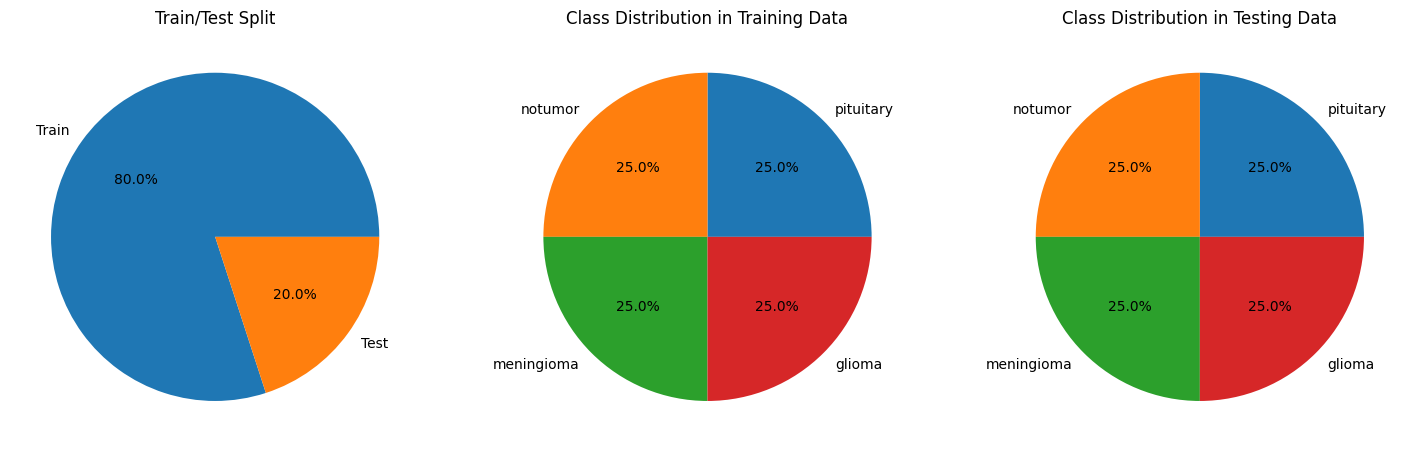

In [35]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=8,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=8,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# Functions to train model

In [36]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.applications import ResNet50
import matplotlib.pyplot as plt

# Define the model creation function
def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(317, activation='relu')(x)
    x = Dropout(0.1506243965737864)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.00034044084878564633), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model training function
def train_model(model, train_generator, test_generator, model_name):
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=50,
        callbacks=[checkpoint, early_stopping]
    )

    return model, history

# Create/Load model

In [37]:
# Check if the model exists, else create and train it
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    model = create_model((224, 224, 3), len(classes))

# Plot the model architecture
plot_model(model, to_file='resnet50_model.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [38]:
model, history = train_model(model, train_generator, test_generator, model_file)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.6510
Epoch 1: val_loss improved from inf to 1.77502, saving model to resnet50_brain_mri.keras
48/48 [==============================] - 43s 221ms/step - loss: 1.0296 - accuracy: 0.6510 - val_loss: 1.7750 - val_accuracy: 0.2500
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7891
Epoch 2: val_loss did not improve from 1.77502
48/48 [==============================] - 8s 164ms/step - loss: 0.6736 - accuracy: 0.7891 - val_loss: 7.9715 - val_accuracy: 0.2500
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8438
Epoch 3: val_loss did not improve from 1.77502
48/48 [==============================] - 9s 186ms/step - loss: 0.4688 - accuracy: 0.8438 - val_loss: 3.7723 - val_accuracy: 0.2500
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8750
Epoch 4: val_loss did not improve from 1.77502


# Testing the model

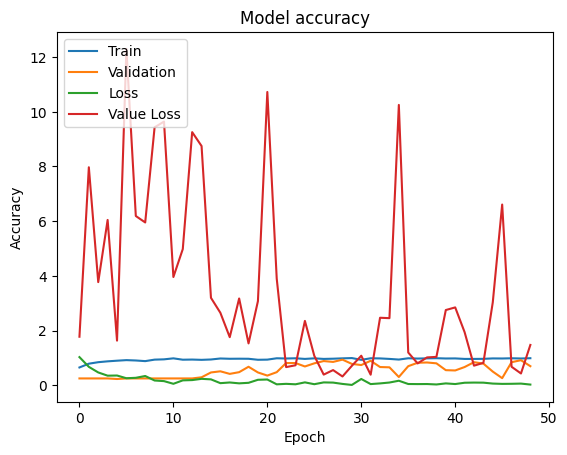

In [39]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

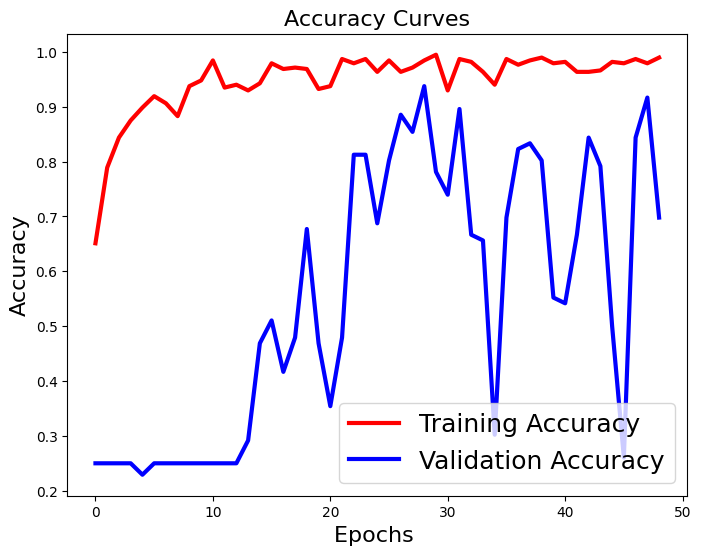

In [40]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

# Validate with external test data

12/12 [==============================] - 1s 32ms/step


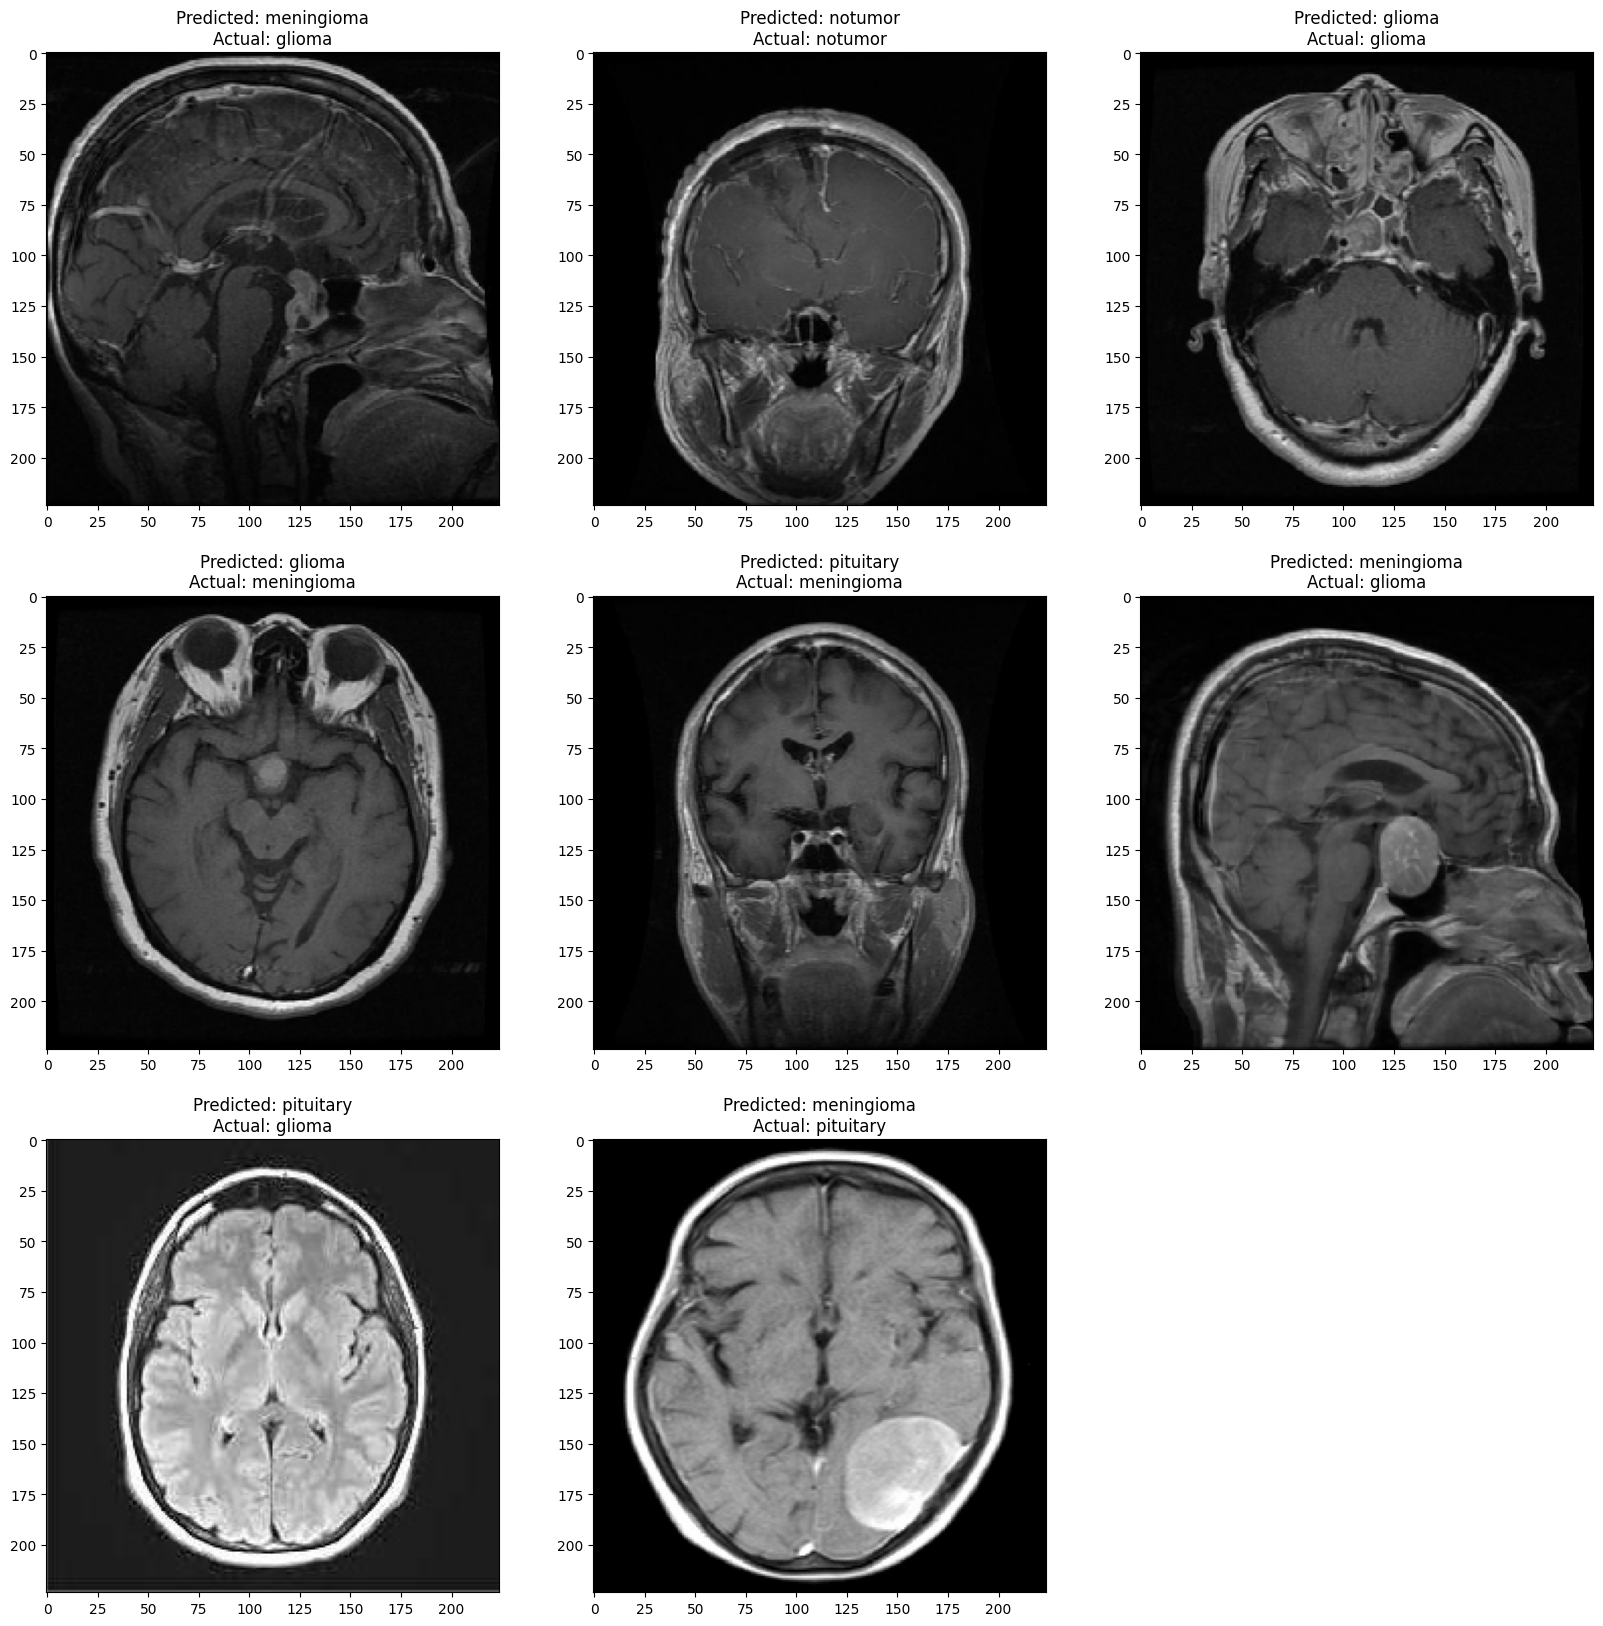

In [41]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break

# Model visualization(Evaluation)

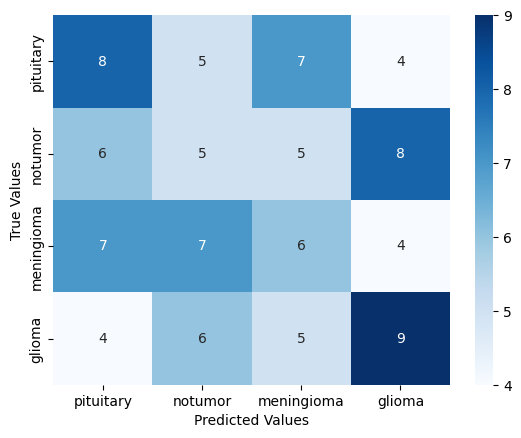

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.2904906643508467, Sensitivity: 0.29166666666666663, Specificity: 0.7638888888888888, Accuracy: 0.2916666666666667
